# Florence2 + SAM2 Inference

In [6]:
# - Packages
import numpy as np
import torch
import cv2
import os

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from torch.utils.data import Dataset, DataLoader

import torch
import supervision as sv

from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)

import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
from tqdm import tqdm
from torchvision.ops import masks_to_boxes

from sklearn.cluster import DBSCAN
import random

import re

In [7]:
# - Global Variables
## - Florence2
data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
test_image_dir = data_dir / 'image_test_pngs'
max_output_token = 2048


CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

label_num = 170

## - Define Dataloader
BATCH_SIZE = 5
NUM_WORKERS = 0

checkpoint_dir = './model_checkpoints/large_model/epoch_700'

## - SAM2

data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
test_image_dir = data_dir / 'image_test_pngs'
test_image_slice_dir = data_dir / "image_slice_test_pngs"
test_image_pred_dir = data_dir / "image_pred_test_pngs"

os.makedirs(test_image_slice_dir, exist_ok=True)
os.makedirs(test_image_pred_dir, exist_ok=True)
sam2_checkpoint = "./sam2_hiera_large.pt"
model_cfg = "./sam2_hiera_l.yaml"
overlapp_ratio = 0.15
finetuned_parameter_path = "./checkpoints/all/large_model_slice_7000.torch"

In [8]:
# - Load Models
model = AutoModelForCausalLM.from_pretrained(checkpoint_dir, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(checkpoint_dir, trust_remote_code=True)
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=DEVICE)
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(finetuned_parameter_path))

<All keys matched successfully>

## Data Preparation

In [9]:
# - slice test images
all_files = np.sort(os.listdir(test_image_dir))
test_image_path_lst = np.array([test_image_dir / test_image_path for test_image_path in all_files])

# - slice image and segmentation for florence sequence length limit
def create_slices(image_path, slice_image_dir):
    img = Image.open(image_path)
     # Get image dimensions
    width, height = img.size
    
    # Calculate the midpoint
    mid_x, mid_y = width // 2, height // 2
    
    # Define the four slices (left, upper, right, lower)
    slices = {
        'top_left': (0, 0, mid_x, mid_y),
        'top_right': (mid_x, 0, width, mid_y),
        'bottom_left': (0, mid_y, mid_x, height),
        'bottom_right': (mid_x, mid_y, width, height)
    }
    
    # Loop through the slices, crop, and save them
    all_slices = []
    for key, coords in slices.items():
        slice_img = img.crop(coords)
        # Format the name: base name + coordinates
        slice_filename = f"{image_path.stem}_{coords[0]}_{coords[1]}_{coords[2]}_{coords[3]}.png"
        slice_img.save( slice_image_dir / slice_filename)
        all_slices.append( slice_image_dir / slice_filename)

    return all_slices

all_test_slices = []

for slice_path in test_image_path_lst:
    all_test_slices += create_slices(slice_path, test_image_slice_dir)



In [10]:
# - check invalid bounding boxes
def validate_boxes(boxes):
    """Validate and filter out invalid bounding boxes."""
    valid_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box[:4]
        if x_max > x_min and y_max > y_min:
            valid_boxes.append(box)
    return valid_boxes

## Florence2 and Sam2 Inference

### Florence2 Inference

In [11]:
# - Define Florence Inference
def flo_infer_bboxes(image_path, max_new_tokens, num_steps = 1):
    max_labels = 0
    max_bboxes = []
    max_image = []
    for i in tqdm(range(num_steps), desc="Florence2 Prediction", leave=False):
        image = cv2.imread(str(image_path))
        image = Image.fromarray(image)
        task = "<OD>"
        text = "<OD>"
        inputs = processor(
            text=text, 
            images=image, 
            return_tensors="pt"
        ).to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=max_new_tokens,
            num_beams=3)
        generated_text = processor.batch_decode(
            generated_ids, skip_special_tokens=False)[0]
        response = processor.post_process_generation(
            generated_text, 
            task=task, 
            image_size=image.size)
        detections = sv.Detections.from_lmm(
            sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

        bounding_box_annotator = sv.BoxAnnotator(
            color_lookup=sv.ColorLookup.INDEX)
        label_annotator = sv.LabelAnnotator(
            color_lookup=sv.ColorLookup.INDEX)

        image = bounding_box_annotator.annotate(image, detections)
        image = label_annotator.annotate(image, detections)
        if len(response['<OD>']['bboxes']) > max_labels:
            max_labels = len(response['<OD>']['bboxes'])
            max_bboxes = response['<OD>']['bboxes']
            max_image = image
    plt.imshow(max_image)
    return max_labels, max_bboxes, max_image

### SAM2 Inference

In [12]:
# - show box and show seg 
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) 

def show_seg(img, seg_map, coords = None, labels = None):
     # - project back to RGB
    rgb_image = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
    for id_class in range(1,seg_map.max()+1):
        rgb_image[seg_map == id_class] = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    plt.figure(figsize=(20, 20))

    # First image (annotation)
    if coords is not None and labels is not None:
        plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
        plt.imshow(rgb_image)
        show_points(coords, labels, plt.gca())
        plt.title('Annotation')
        plt.axis('off')  # Hide the axis
    else:
        plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
        plt.imshow(rgb_image)
        plt.title('Annotation')
        plt.axis('off')  # Hide the axis

    # Second image (mix)
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
    mix_image = (rgb_image / 2 + img / 2).astype(np.uint8)
    plt.imshow(mix_image)
    plt.title('Mix')
    plt.axis('off')

    # Third image (original image)
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.tight_layout()  # Adjust the layout so everything fits without overlap
    plt.show()

    return rgb_image
    

In [13]:
# - SAM2 Predict Segmentation
def predict_seg(
    img: np.ndarray,
    input_points: np.ndarray = None,
    point_labels: np.ndarray = None,
    input_boxes: np.ndarray = None,
    multimask_output: bool = False
) -> np.ndarray:
    torch.autocast(device_type='cpu', dtype=torch.bfloat16).__enter__()
    with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
            predictor.set_image(img) # image encoder
            masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
                point_coords=input_points,
                point_labels=point_labels,
                box = input_boxes,
                multimask_output=multimask_output)
            
    # - sort masks based on their scores (high-quality segmentation)
    shorted_masks = masks[np.argsort(scores[:,0])[::-1], :, :, :].astype(bool)
    seg_map = np.zeros_like(shorted_masks[0, 0, ...], dtype=np.uint8)
    occupancy_mask = np.zeros_like(shorted_masks[0, 0, ...],dtype=bool)

    # - add the masks one by one from high to low score
    for i in range(shorted_masks.shape[0]):
        if multimask_output:
            mask_lst = shorted_masks[i]
            score_lst = scores[i]
            score_rank = np.argsort(score_lst)[::-1]
            sorted_mask_lst = mask_lst[score_rank]
            for mask in sorted_mask_lst:
                if (mask*occupancy_mask).sum()/mask.sum() <= overlapp_ratio:
                    mask[occupancy_mask]=0
                    seg_map[mask]=i+1
                    occupancy_mask[mask]=1
                    break
        else:
             mask = shorted_masks[i, 0, ...]
             if (mask*occupancy_mask).sum()/mask.sum() <= overlapp_ratio:
                mask[occupancy_mask]=0
                seg_map[mask]=i+1
                occupancy_mask[mask]=1
        
    # - project back to RGB
    rgb_image = show_seg(img, seg_map)
    return occupancy_mask, seg_map, rgb_image

In [14]:
# - Post Predict Segmentation
def post_predict_seg(
    img: np.ndarray,
    occupancy_mask,
    seg_map,
    input_points: np.ndarray = None,
    point_labels: np.ndarray = None,
    input_boxes: np.ndarray = None,
    multimask_output: bool = False,
) -> np.ndarray:
    torch.autocast(device_type='cpu', dtype=torch.bfloat16).__enter__()
    with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
            predictor.set_image(img) # image encoder
            masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
                point_coords=input_points,
                point_labels=point_labels,
                box = input_boxes,
                multimask_output=multimask_output)
            
    # - sort masks based on their scores (high-quality segmentation)
    if len(masks.shape) == 3:
        masks = masks.reshape((1, masks.shape[0], masks.shape[1], masks.shape[2]))
        scores = scores.reshape((1, len(scores)))
    shorted_masks = masks[np.argsort(scores[:,0])[::-1], :, :, :].astype(bool)
    seg_map = seg_map
    occupancy_mask = occupancy_mask
    max_id = np.max(seg_map) + 1

    # - add the masks one by one from high to low score
    for i in range(shorted_masks.shape[0]):
        if multimask_output:
            mask_lst = shorted_masks[i]
            score_lst = scores[i]
            score_rank = np.argsort(score_lst)[::-1]
            sorted_mask_lst = mask_lst[score_rank]
            for mask in sorted_mask_lst:
                if (mask*occupancy_mask).sum()/mask.sum() <= overlapp_ratio:
                    mask[occupancy_mask]=0
                    seg_map[mask]=max_id + i
                    occupancy_mask[mask]=1
                    break
        else:
             mask = shorted_masks[i, 0, ...]
             if (mask*occupancy_mask).sum()/mask.sum() <= overlapp_ratio:
                mask[occupancy_mask]=0
                seg_map[mask]=max_id + i
                occupancy_mask[mask]=1
        
    # - project back to RGB
    rgb_image = show_seg(img, seg_map)
    return occupancy_mask, seg_map, rgb_image

the number of labels: 3


Falling back to all available kernels for scaled_dot_product_attention (which may have a slower speed).


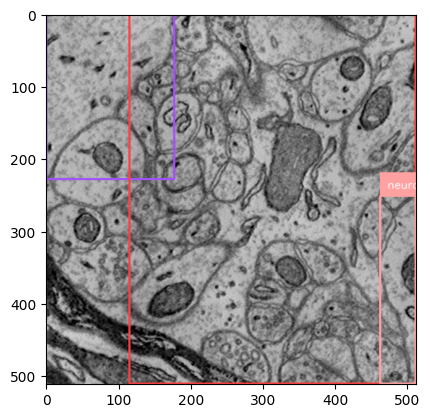

In [15]:
# - Florence2 + SAM2 Test Sample Image: only bboxes
image_path = all_test_slices[0]
num_labels, bboxes, image = flo_infer_bboxes(image_path, 2048, num_steps = 1)
print(f'the number of labels: {num_labels}')

# - Fliter Invalid Bound Boxes
bboxes = validate_boxes(bboxes)
image = cv2.imread(str(image_path))
occupancy_mask, seg_map, rgb_image = predict_seg( image , None, None, input_boxes = bboxes)

### Multiple Mask Selection and Duplicate Inference Correction


In [16]:
# - Select Sparse Coordinates

def select_sparse_coordinates(occupancy_mask, 
    erode_kernel_size: tuple = (2, 2),
    erode_iterations: int = 10,
    dilate_kernel_size: tuple = (2, 2),
    dilate_iterations: int = 2,
    contour_area_threshold: int = 100
) -> np.ndarray:
    """
    Processes the input mask by performing erosion, dilation, contour filtering, 
    and marking centroids of the contours.
    
    Parameters:
    mask (np.ndarray): Input binary mask image.
    erode_kernel_size (tuple): Kernel size for erosion.
    erode_iterations (int): Number of iterations for erosion.
    dilate_kernel_size (tuple): Kernel size for dilation.
    dilate_iterations (int): Number of iterations for dilation.
    contour_area_threshold (int): Minimum area for contours to be considered valid.
    
    Returns:
    np.ndarray: Processed image with centroids marked.
    """
    
    # Step 3: Erode the mask
    img_inv = np.uint8(~occupancy_mask * 255)
    kernel = np.ones(erode_kernel_size, np.uint8)
    morphed_inv_mask = cv2.erode(img_inv, kernel, iterations=erode_iterations)

    # Step 4: Filter contours based on area threshold
    filt_inv_mask = np.zeros_like(morphed_inv_mask, dtype=np.uint8)
    contours, _ = cv2.findContours(morphed_inv_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cntr in contours:
        if cv2.contourArea(cntr) > contour_area_threshold:
            cv2.drawContours(filt_inv_mask, [cntr], -1, 255, thickness=cv2.FILLED)

    # Step 5: Dilate the filtered mask
    kernel = np.ones(dilate_kernel_size, np.uint8)
    morphed_filt_mask = cv2.dilate(filt_inv_mask, kernel, iterations=dilate_iterations)

    # Step 6: Find centroids of the remaining contours and collect coordinates
    centroids = []
    contours, _ = cv2.findContours(morphed_filt_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cntr in contours:
        M = cv2.moments(cntr)
        if M['m00'] != 0:  # Avoid division by zero
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroids.append((cx, cy))

    # Convert list of centroids to a NumPy array
    return np.array(centroids)
    

In [17]:
# - flo + sam inference
def flo_sam_infer(image_path, num_corr = 5, num_steps = 10):
    num_labels, bboxes, image = flo_infer_bboxes(image_path, 2048, num_steps=num_steps)
    bboxes = validate_boxes(bboxes)
    img = cv2.imread(str(image_path))
    occupancy_mask, seg_map, rgb_image = predict_seg( img , None, None, input_boxes = bboxes)

    for i in tqdm(range(num_corr), desc='Continuous Correction', leave = False):
        false_coordinates = np.array(select_sparse_coordinates(occupancy_mask))
        false_labels = np.ones([false_coordinates.shape[0],])

        # reshape coordinates and prepare labels
        show_seg(img, seg_map, false_coordinates, false_labels)
        false_coordinates = false_coordinates.reshape((false_coordinates.shape[0], 1, false_coordinates.shape[1]))
        false_labels = np.ones([false_coordinates.shape[0], 1])

        occupancy_mask, seg_map, rgb_image = post_predict_seg( img, occupancy_mask, seg_map, input_points = false_coordinates, point_labels = false_labels, multimask_output=True)
    
    return rgb_image


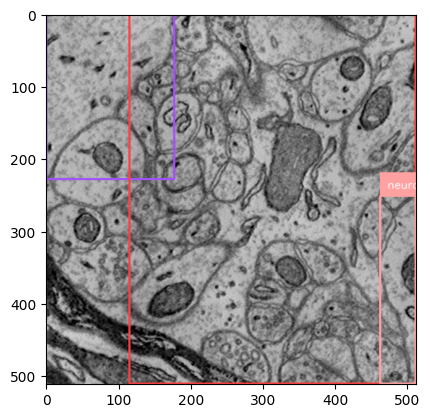

In [18]:

image_path = all_test_slices[0]
rgb_image = flo_sam_infer(image_path, num_corr = 1, num_steps = 1)

### Merge Instance Segmentation

In [19]:
# - convert to binary mask
def convert_binary_mask(masks, image_seg, coords, total_shape):
    image_seg = image_seg[...,0]
     # get bounding boxes from the mask
    inds = np.unique(image_seg)[1:]  # load all indices
    xmin, ymin, xmax, ymax = coords

    # Prepare an empty mask with the total shape (e.g., 1024x1024)
    # Get binary masks and points
    
    masks = masks
    for ind in inds:
        total_mask = np.zeros(total_shape, dtype=np.uint8)
        mask = (image_seg == ind).astype(np.uint8)
        total_mask[ymin:ymax, xmin:xmax] = mask
        masks.append(total_mask)
    masks = np.array(masks)

    mask_tensor = torch.from_numpy(masks)

    boxes = masks_to_boxes(mask_tensor)

    return masks, boxes.numpy()

In [20]:
# image_sample = "image0000"
# image_sample_path_lst = all_test_slices[:4]
# total_shape = (1024, 1024)
# binary_masks = []
# for image_path in image_sample_path_lst:
#     rgb_seg = flo_sam_infer(image_path, num_corr=10)
#     coords = image_path.stem.split("_")[1:]
#     coords = [int(x) for x in coords]
#     binary_masks = list(binary_masks)
#     binary_masks, mask_boxes = convert_binary_mask(binary_masks, rgb_seg, coords, (1024, 1024))


# combined_mask = np.sum(binary_masks, axis=0) > 0  # Sum all masks and threshold (1 if any overlap)
# plt.figure(figsize=(15, 15))
# plt.imshow(combined_mask, cmap='gray')
# plt.title('Combined Binary Mask')
# plt.axis('off')  # Hide axis labels and ticks
# plt.show()


### Slice Inference Implementation

In [23]:
class ImageSlicer:
    def __init__(self, image_path: str, slice_size: tuple, overlap_ratio: float, output_dir: str):
        self.image_path = image_path
        self.slice_size = slice_size
        self.overlap_ratio = overlap_ratio
        self.output_dir = output_dir

        # Create output directory if it doesn't exist
        os.makedirs(self.output_dir, exist_ok=True)
        
        # Load the image
        self.image = Image.open(self.image_path)
        self.image_width, self.image_height = self.image.size

    # - slicer padding problem
    def slice_image(self):
        # Calculate the step size based on the overlap ratio
        step_size_x = int(self.slice_size[0] * (1 - self.overlap_ratio))
        step_size_y = int(self.slice_size[1] * (1 - self.overlap_ratio))

        slice_paths = []
        slice_number = 0

        # Loop through the image dimensions to create overlapping slices
        for y in range(0, self.image_height , step_size_y):
            for x in range(0, self.image_width , step_size_x):
                # Define the box for cropping
                box = [x, y, min(x + self.slice_size[0], self.image_width), 
                             min(y + self.slice_size[1], self.image_height)]
                if box[2] == self.image_width:
                    box[0] = self.image_width- self.slice_size[0]
                if box[3] == self.image_height:
                    box[1] = self.image_height- self.slice_size[1]
                slice_img = self.image.crop(box)

                # Save the slice with the coordinates in the filename
                slice_filename = f"{os.path.basename(self.image_path).split('.')[0]}_{box[0]}_{box[1]}_{box[2]}_{box[3]}.png"
                slice_path = os.path.join(self.output_dir, slice_filename)
                
                # Save the slice and append to the list of paths
                slice_img.save(slice_path)
                slice_paths.append(Path(slice_path))

                slice_number += 1

        return slice_paths

    def display_images_in_grid(self, image_paths):
        num_images = len(image_paths)
    
        # Determine the grid size: (cols, rows)
        cols = int(num_images**0.5)
        rows = (num_images // cols) + (num_images % cols > 0)
    
        # Create a figure with subplots
        fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    
        # Flatten axes array in case of multiple rows and columns
        axes = axes.flatten() if num_images > 1 else [axes]
    
        for i, image_path in enumerate(image_paths):
            img = Image.open(image_path)  # Open the image
            axes[i].imshow(img)           # Display the image
            axes[i].axis('off')           # Hide axes for better appearance
    
        # Remove any unused subplots (if the grid is larger than the number of images)
        for ax in axes[num_images:]:
            ax.remove()
    
        plt.tight_layout()
        plt.show()

    def convert_binary_mask(masks, image_seg, coords, total_shape):
        image_seg = image_seg[...,0]
        # get bounding boxes from the mask
        inds = np.unique(image_seg)[1:]  # load all indices
        xmin, ymin, xmax, ymax = coords

        # Prepare an empty mask with the total shape (e.g., 1024x1024)
        # Get binary masks and points
    
        masks = masks
        for ind in inds:
            total_mask = np.zeros(total_shape, dtype=np.uint8)
            mask = (image_seg == ind).astype(np.uint8)
            total_mask[ymin:ymax, xmin:xmax] = mask
            masks.append(total_mask)
        masks = np.array(masks)

        mask_tensor = torch.from_numpy(masks)

        boxes = masks_to_boxes(mask_tensor)

        return masks, boxes.numpy()

    def run_segmentation(self, slice_paths, total_shape, num_corr = 10, num_steps = 1):
        binary_masks = []
        for image_path in tqdm(slice_paths, desc = "Running Segmentation"):
            rgb_seg = flo_sam_infer(image_path, num_corr = num_corr, num_steps = num_steps)
            coords = image_path.stem.split("_")[1:]
            coords = [int(x) for x in coords]
            binary_masks = list(binary_masks)
            binary_masks, mask_boxes = convert_binary_mask(binary_masks, rgb_seg, coords, total_shape)
        combined_mask = np.sum(binary_masks, axis=0) > 0  # Sum all masks and threshold (1 if any overlap)
        plt.figure(figsize=(15, 15))
        plt.imshow(combined_mask, cmap='gray')
        plt.title('Combined Binary Mask')
        plt.axis('off')  # Hide axis labels and ticks
        plt.show()
        
        return combined_mask
    

[0, 0, 512, 512]
[128, 0, 640, 512]
[256, 0, 768, 512]
[384, 0, 896, 512]
[512, 0, 1024, 512]
[512, 0, 1024, 512]
[512, 0, 1024, 512]
[512, 0, 1024, 512]
[0, 128, 512, 640]
[128, 128, 640, 640]
[256, 128, 768, 640]
[384, 128, 896, 640]
[512, 128, 1024, 640]
[512, 128, 1024, 640]
[512, 128, 1024, 640]
[512, 128, 1024, 640]
[0, 256, 512, 768]
[128, 256, 640, 768]
[256, 256, 768, 768]
[384, 256, 896, 768]
[512, 256, 1024, 768]
[512, 256, 1024, 768]
[512, 256, 1024, 768]
[512, 256, 1024, 768]
[0, 384, 512, 896]
[128, 384, 640, 896]
[256, 384, 768, 896]
[384, 384, 896, 896]
[512, 384, 1024, 896]
[512, 384, 1024, 896]
[512, 384, 1024, 896]
[512, 384, 1024, 896]
[0, 512, 512, 1024]
[128, 512, 640, 1024]
[256, 512, 768, 1024]
[384, 512, 896, 1024]
[512, 512, 1024, 1024]
[512, 512, 1024, 1024]
[512, 512, 1024, 1024]
[512, 512, 1024, 1024]
[0, 512, 512, 1024]
[128, 512, 640, 1024]
[256, 512, 768, 1024]
[384, 512, 896, 1024]
[512, 512, 1024, 1024]
[512, 512, 1024, 1024]
[512, 512, 1024, 1024]
[51

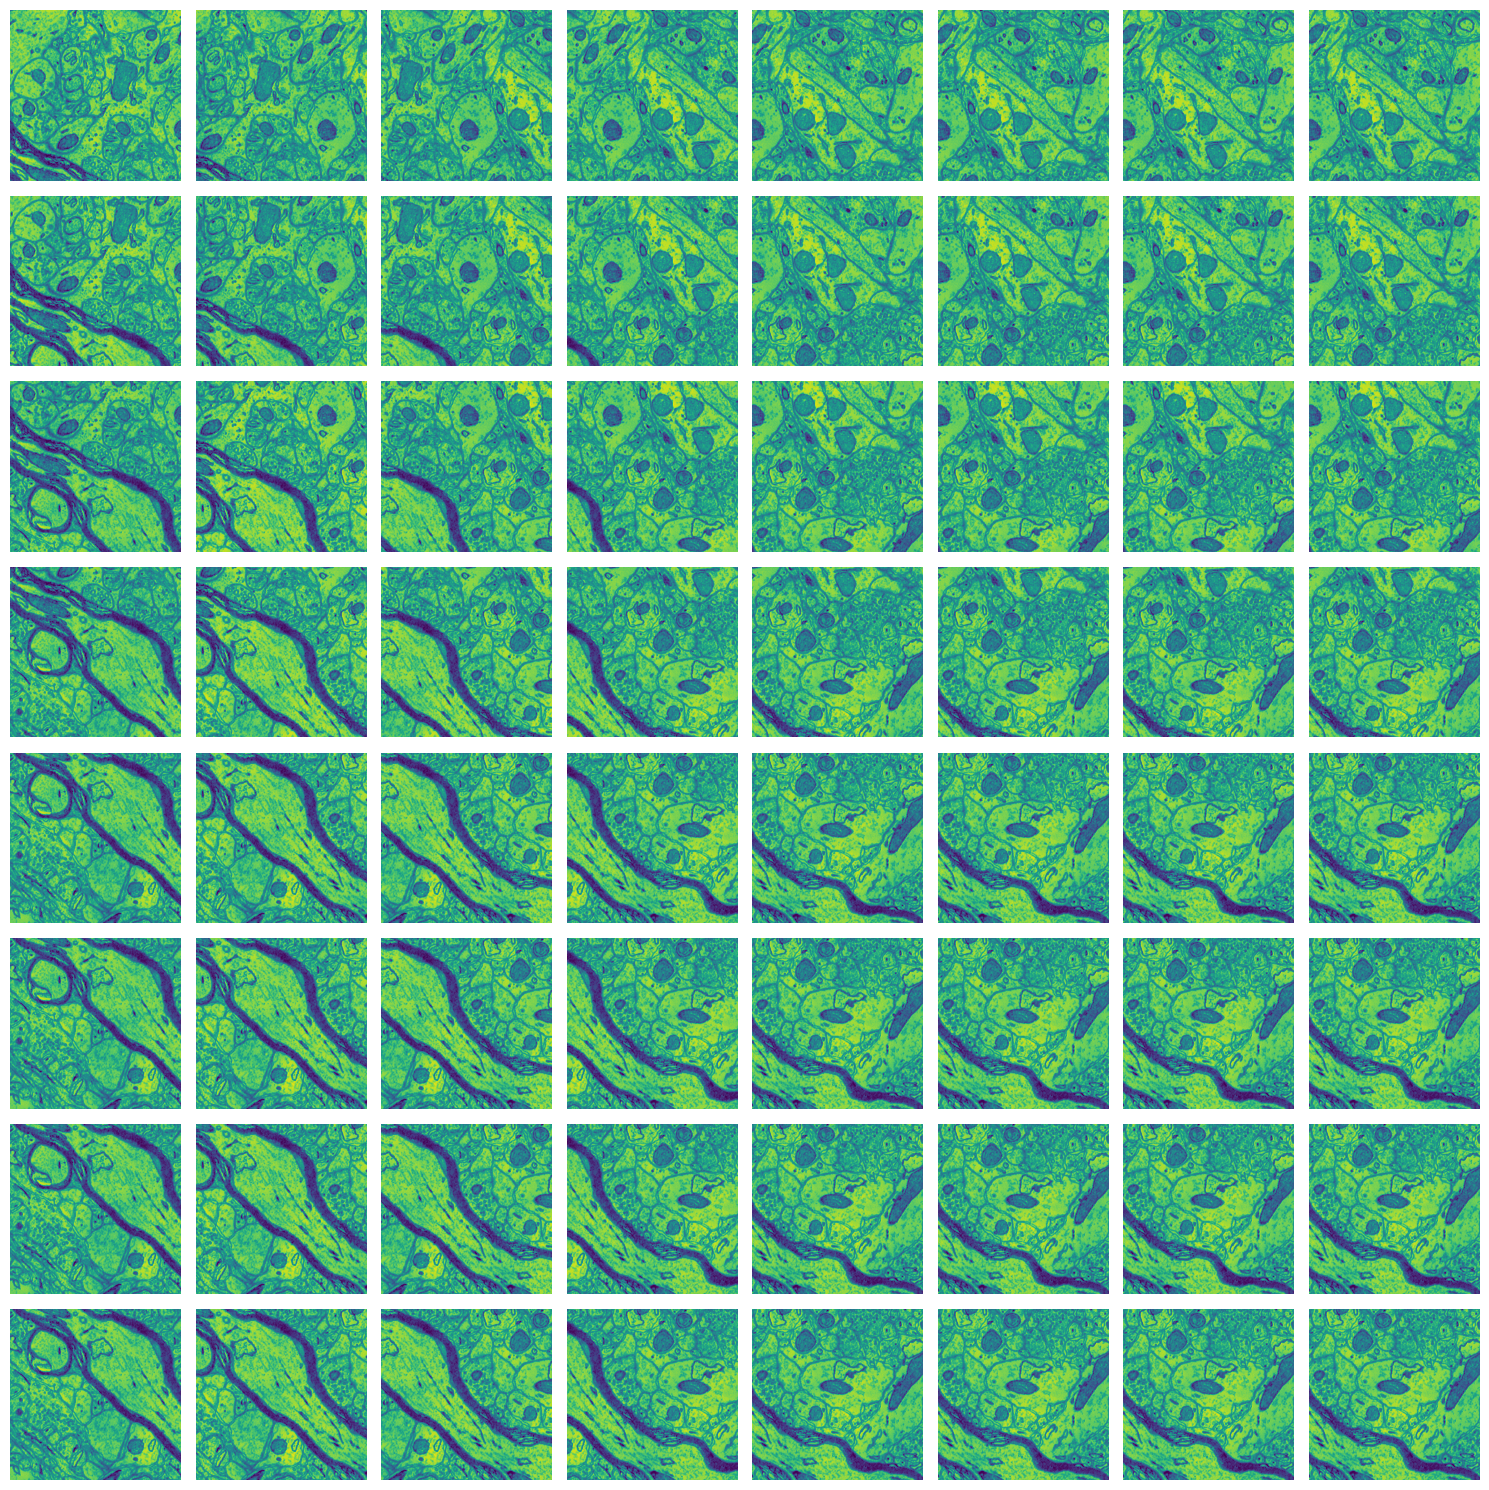

In [24]:
image_sample_slicer = ImageSlicer(test_image_path_lst[0], (512, 512), 0.75, test_image_slice_dir)
slice_lst = image_sample_slicer.slice_image()
image_sample_slicer.display_images_in_grid(slice_lst)

In [25]:
full_binary_mask = image_sample_slicer.run_segmentation(slice_lst, (1024, 1024), num_corr=10, num_steps=5)

Running Segmentation:  28%|██▊       | 18/64 [10:36<28:47, 37.56s/it]

In [ ]:
full_binary_image = Image.fromarray(full_binary_mask)
img_id = re.findall(r'\d+', image_sample_slicer.image_path.stem)

temp_path = test_image_pred_dir / ('seg' + img_id[0] + '.png')
full_binary_image.save(temp_path)